In [3]:
# unzip the file
!tar zxvf cifar100.tar.gz

cifar100/
cifar100/train.pt

gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:

train_set = torch.load("cifar100/train.pt")
valid_set = torch.load("cifar100/valid.pt")

batch_size = 64
train_loader = DataLoader(train_set, batch_size, shuffle=False)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False)

/tmp/ipykernel_315344/4007758603.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_set = torch.load("cifar100/train.pt")
/tmp/ipykernel_315344/4007758603.py:2: Futur

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38757783..1.3280318].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2201426..1.5055748].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4478504..1.3848456].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25762337..1.106117].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4478504..1.2087374].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4028666..1.3113579].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21328

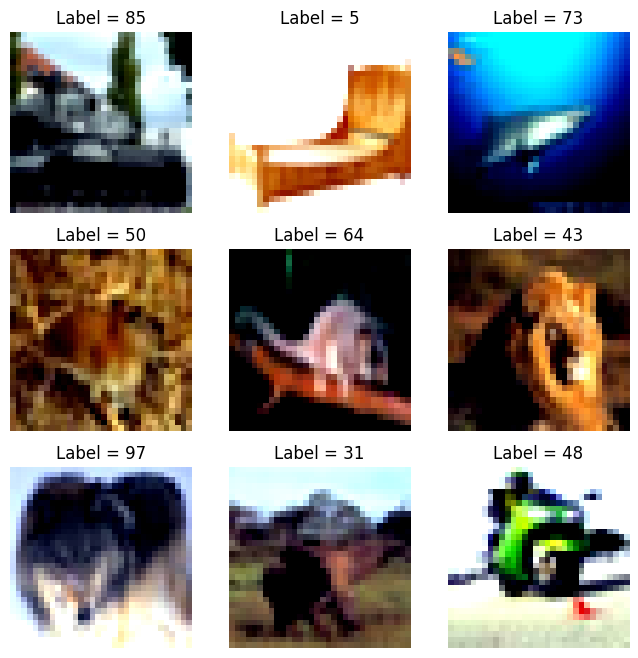

In [3]:
## show the read pictures randomly
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img = train_set[sample_idx][0].numpy().transpose(1, 2, 0)
    label = train_set[sample_idx][1]
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title("Label = {}".format(label))
    plt.axis("off")

    img = img / 2 + 0.5
    
    plt.imshow(img.squeeze())
plt.show()

# Model

In [4]:
from network import EfficientMobileNetV3, load_model


# Check for GPU availability
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
num_classes = 100  # For CIFAR-100
model = EfficientMobileNetV3(num_classes=num_classes).to(DEVICE)


In [5]:

####################  Training Phase  ###################################
# Training loop

def train_phase(model, train_loader, optimizer, criterion, device):

    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, targets in train_loader:
        # Move data to the appropriate device
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy



Epoch 1/130
Train Loss: 4.1344, Train Accuracy: 5.57%
Validation Loss: 3.9093, Validation Accuracy: 8.07%
Saved Best Model
Learning Rate: 0.010000
Epoch 2/130
Train Loss: 3.6396, Train Accuracy: 12.40%
Validation Loss: 3.4744, Validation Accuracy: 15.23%
Saved Best Model
Learning Rate: 0.010000
Epoch 3/130
Train Loss: 3.2623, Train Accuracy: 18.77%
Validation Loss: 3.2274, Validation Accuracy: 20.47%
Saved Best Model
Learning Rate: 0.010000
Epoch 4/130
Train Loss: 2.9688, Train Accuracy: 24.14%
Validation Loss: 2.8770, Validation Accuracy: 26.42%
Saved Best Model
Learning Rate: 0.010000
Epoch 5/130
Train Loss: 2.7446, Train Accuracy: 28.81%
Validation Loss: 2.6591, Validation Accuracy: 30.30%
Saved Best Model
Learning Rate: 0.010000
Epoch 6/130
Train Loss: 2.5493, Train Accuracy: 32.72%
Validation Loss: 2.4781, Validation Accuracy: 34.81%
Saved Best Model
Learning Rate: 0.010000
Epoch 7/130
Train Loss: 2.3889, Train Accuracy: 36.12%
Validation Loss: 2.3870, Validation Accuracy: 35.90%


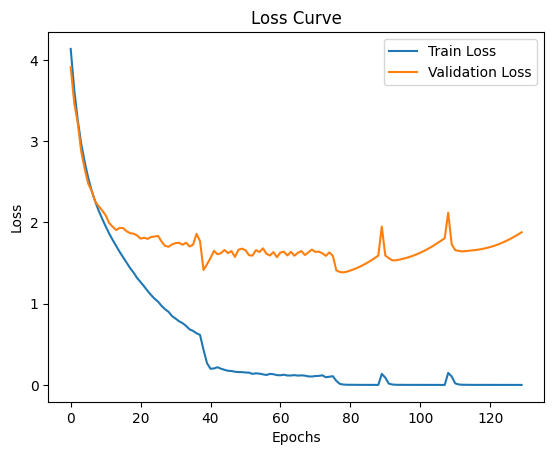

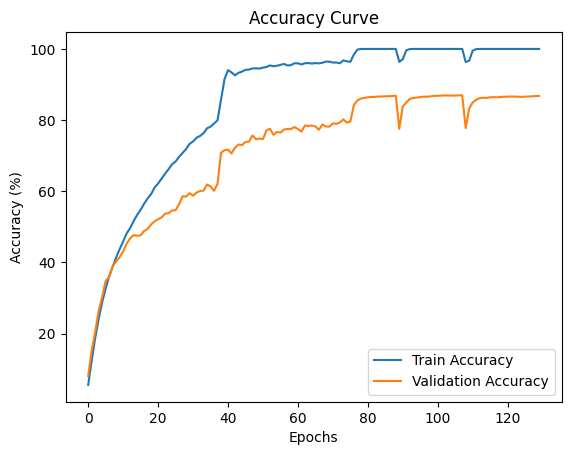

In [6]:
####################  Validation Phase  ###################################
# Testing loop
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)


# Define scheduler
scheduler = StepLR(optimizer, step_size=38,gamma=0.5)  # 每隔 40 个 epoch 学习率乘以 0.1
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay = 1e-4)

# milestones 表示學習率下降的 Epoch，gamma 是下降倍率
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 70 , 80], gamma=0.1)

import matplotlib.pyplot as plt

# Initialize arrays to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

####################  Validation Phase  ###################################
# Testing loop
def validate_phase(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in val_loader:
            # Move data to the appropriate device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Accumulate loss
            running_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = running_loss / len(val_loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy


# Training and validation loop
num_epochs = 130
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    # Train and validate in a single epoch
    train_loss, train_acc = train_phase(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = validate_phase(model, valid_loader, criterion, DEVICE)

    # Step the scheduler (for StepLR or similar schedulers)
    scheduler.step()  # 在每个 epoch 结束时调用
        # Record metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print summary for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # Save the best model
    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), "model.pth")
        print("Saved Best Model")

    # Print current learning rate
    for param_group in optimizer.param_groups:
        print(f"Learning Rate: {param_group['lr']:.6f}")

# Plot training and validation curves
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.show()